In [ ]:
pip install geopandas rasterio shapely numpy matplotlib pandas scipy scikit-image pyproj reportlab tqdm requests elevation rtree

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.4/338.4 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 159.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 146.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 193.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 129.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.5/32.5 MB 152.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive

Mounted at /content/drive
 10-3-2025-Lecture
 2024-2025
 20250502_203317.mp4
'24-25 Canyon Point A7'
'5 3 Plan.gdoc'
 ACM
'ACM Group Planning.gdoc'
'AI Project + Da-Yi Wu + TzuChing Wu.gdoc'
 BFR
'Class Plan.gsheet'
 Clubs
'Colab Notebooks'
 Courant-John_introduction-to-calculus-and-analysis-v2.pdf
 cropped_map.tif
'Da-Yi_Resume (1).pdf'
'Deluxe vs Plaza.gdoc'
'Final Reflection.gdoc'
 Gym
 half_marathon_training_plan.csv
'Health Monitor.gslides'
 IMG_7303.MOV
'LA Phil'
'Math 142 Assignment 2.gdoc'
'Math 142 Group Planning Doc.gdoc'
'Math 142 Iteration 3.ipynb'
 Math142_iteration4.ipynb
'Math 142 Monday Week 6 photos'
'Monte Carlo Methods intro'
 new2_cropped_map.tif
 new_cropped_map.tif
 Photos
'Project Pitch.gdoc'
'Project Technical Report.gdoc'
'Prompt for 142.gdoc'
'published lectures'
'Questions for interview.gdoc'
 rapid_bushfire_response_model.ipynb
'Routes Around UCLA.gdoc'
 Running.gsheet
'Sickness detection project.gdoc'
'Symphony 24-25'
'Symphony Roster 2025-26 .pdf'
 TrashNe

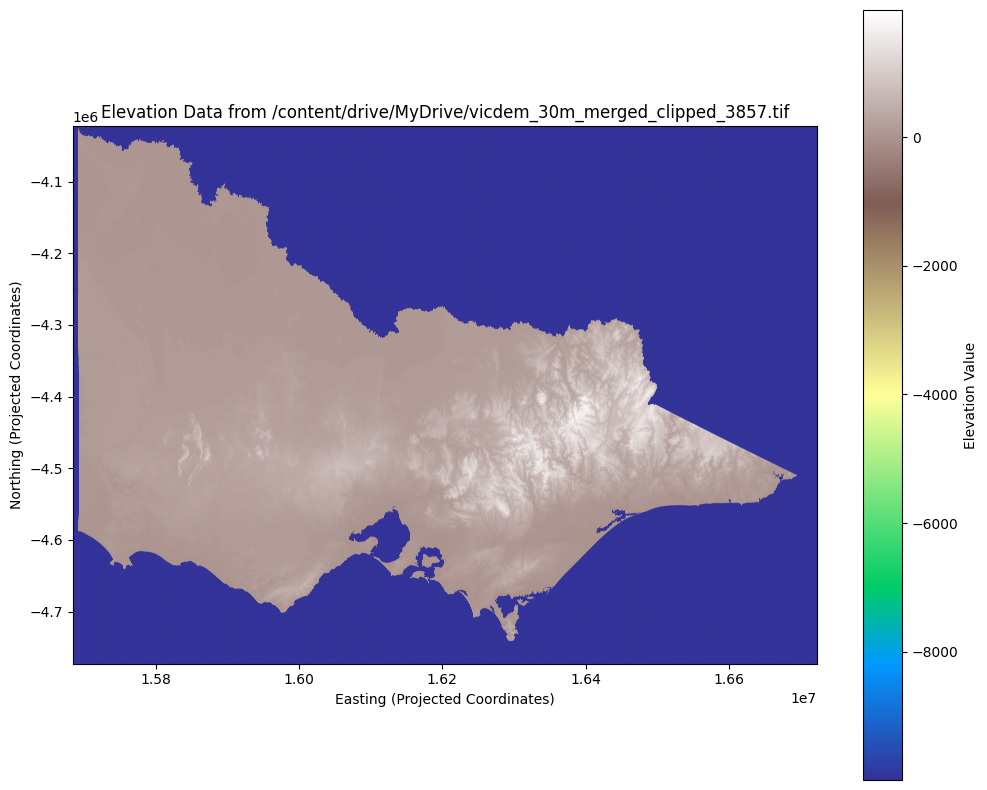

Successfully loaded and displayed /content/drive/MyDrive/vicdem_30m_merged_clipped_3857.tif
Image shape: (22712, 31441)
Data type: float32
Coordinate Reference System (CRS): EPSG:3857
Bounds: BoundingBox(left=15684746.181357015, bottom=-4772636.555966763, right=16722643.67821714, top=-4022891.7021552706)


In [ ]:
import rasterio
import matplotlib.pyplot as plt

file_path = '/content/drive/MyDrive/vicdem_30m_merged_clipped_3857.tif'


  # Open the GeoTIFF file in read mode
with rasterio.open(file_path) as src:
# Read the first band of the raster (assuming elevation is in the first band)
  image_data = src.read(1)

  # Display the image
  plt.figure(figsize=(12, 10))
  plt.imshow(image_data, cmap='terrain', origin='upper',
              extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
  plt.title(f'Elevation Data from {file_path}')
  plt.xlabel('Easting (Projected Coordinates)')
  plt.ylabel('Northing (Projected Coordinates)')
  plt.colorbar(label='Elevation Value')
  plt.show()

  print(f"Successfully loaded and displayed {file_path}")
  print(f"Image shape: {image_data.shape}")
  print(f"Data type: {image_data.dtype}")
  print(f"Coordinate Reference System (CRS): {src.crs}")
  print(f"Bounds: {src.bounds}")



In [ ]:
import numpy as np
import rasterio

# Re-define file_path and re-extract elevation_data and resolution
file_path = '/content/drive/MyDrive/vicdem_30m_merged_clipped_3857.tif'

with rasterio.open(file_path) as src:
    elevation_data = src.read(1)
    resolution = src.res[0]

# Re-calculate slope_degrees (as done in cell 5892dd57)
# Identify and handle 'no-data' values (e.g., -9999) by replacing them with np.nan
elevation_data_processed = elevation_data.copy()
elevation_data_processed[elevation_data_processed == -9999] = np.nan

# Calculate the gradient in the y-direction (rows) and x-direction (columns)
grad_y, grad_x = np.gradient(elevation_data_processed)

# Account for the pixel resolution by dividing grad_y and grad_x by the resolution variable
grad_y_res = grad_y / resolution
grad_x_res = grad_x / resolution

# Calculate the total slope magnitude for each pixel
slope_magnitude = np.sqrt(grad_x_res**2 + grad_y_res**2)

# Convert the slope magnitude from rise-over-run to degrees
slope_degrees = np.arctan(slope_magnitude) * (180 / np.pi)

# Initialize a new NumPy array for the new classification
terrain_classification_new = np.full(slope_degrees.shape, np.nan, dtype=float)

# Define the slope thresholds (assuming threshold_1_deg, threshold_10_deg etc. are in kernel state)
threshold_1_deg = 1
threshold_10_deg = 10
threshold_20_deg = 20
threshold_30_deg = 30
threshold_40_deg = 40

mask_cat0 = (slope_degrees < threshold_1_deg) & np.isfinite(slope_degrees)
mask_cat1 = (slope_degrees >= threshold_1_deg) & (slope_degrees < threshold_10_deg) & np.isfinite(slope_degrees)
mask_cat2 = (slope_degrees >= threshold_10_deg) & (slope_degrees < threshold_20_deg) & np.isfinite(slope_degrees)
mask_cat3 = (slope_degrees >= threshold_20_deg) & (slope_degrees < threshold_30_deg) & np.isfinite(slope_degrees)
mask_cat4 = (slope_degrees >= threshold_30_deg) & (slope_degrees < threshold_40_deg) & np.isfinite(slope_degrees)
mask_cat5 = (slope_degrees >= threshold_40_deg) & np.isfinite(slope_degrees)

# Assign numerical values to terrain_classification_new based on the masks
terrain_classification_new[mask_cat0] = 0
terrain_classification_new[mask_cat1] = 1
terrain_classification_new[mask_cat2] = 2
terrain_classification_new[mask_cat3] = 3
terrain_classification_new[mask_cat4] = 4
terrain_classification_new[mask_cat5] = 5

# Count the number of pixels in each category
pixels_cat0 = np.sum(mask_cat0)
pixels_cat1 = np.sum(mask_cat1)
pixels_cat2 = np.sum(mask_cat2)
pixels_cat3 = np.sum(mask_cat3)
pixels_cat4 = np.sum(mask_cat4)
pixels_cat5 = np.sum(mask_cat5)

print(f"Pixels in Category 0 (<1 degree): {pixels_cat0}")
print(f"Pixels in Category 1 (1-10 degrees): {pixels_cat1}")
print(f"Pixels in Category 2 (11-20 degrees): {pixels_cat2}")
print(f"Pixels in Category 3 (21-30 degrees): {pixels_cat3}")
print(f"Pixels in Category 4 (31-40 degrees): {pixels_cat4}")
print(f"Pixels in Category 5 (>40 degrees): {pixels_cat5}")

Pixels in Category 0 (<1 degree): 168667585
Pixels in Category 1 (1-10 degrees): 115207078
Pixels in Category 2 (11-20 degrees): 31320710
Pixels in Category 3 (21-30 degrees): 10076219
Pixels in Category 4 (31-40 degrees): 885505
Pixels in Category 5 (>40 degrees): 11721


In [ ]:
total_valid_pixels_new = pixels_cat0 + pixels_cat1 + pixels_cat2 + pixels_cat3 + pixels_cat4 + pixels_cat5

percentage_cat0 = (pixels_cat0 / total_valid_pixels_new) * 100
percentage_cat1 = (pixels_cat1 / total_valid_pixels_new) * 100
percentage_cat2 = (pixels_cat2 / total_valid_pixels_new) * 100
percentage_cat3 = (pixels_cat3 / total_valid_pixels_new) * 100
percentage_cat4 = (pixels_cat4 / total_valid_pixels_new) * 100
percentage_cat5 = (pixels_cat5 / total_valid_pixels_new) * 100

print(f"Percentage of Category 0 (<1 degree): {percentage_cat0:.2f}%")
print(f"Percentage of Category 1 (1-10 degrees): {percentage_cat1:.2f}%")
print(f"Percentage of Category 2 (11-20 degrees): {percentage_cat2:.2f}%")
print(f"Percentage of Category 3 (21-30 degrees): {percentage_cat3:.2f}%")
print(f"Percentage of Category 4 (31-40 degrees): {percentage_cat4:.2f}%")
print(f"Percentage of Category 5 (>40 degrees): {percentage_cat5:.2f}%")

Percentage of Category 0 (<1 degree): 51.71%
Percentage of Category 1 (1-10 degrees): 35.32%
Percentage of Category 2 (11-20 degrees): 9.60%
Percentage of Category 3 (21-30 degrees): 3.09%
Percentage of Category 4 (31-40 degrees): 0.27%
Percentage of Category 5 (>40 degrees): 0.00%


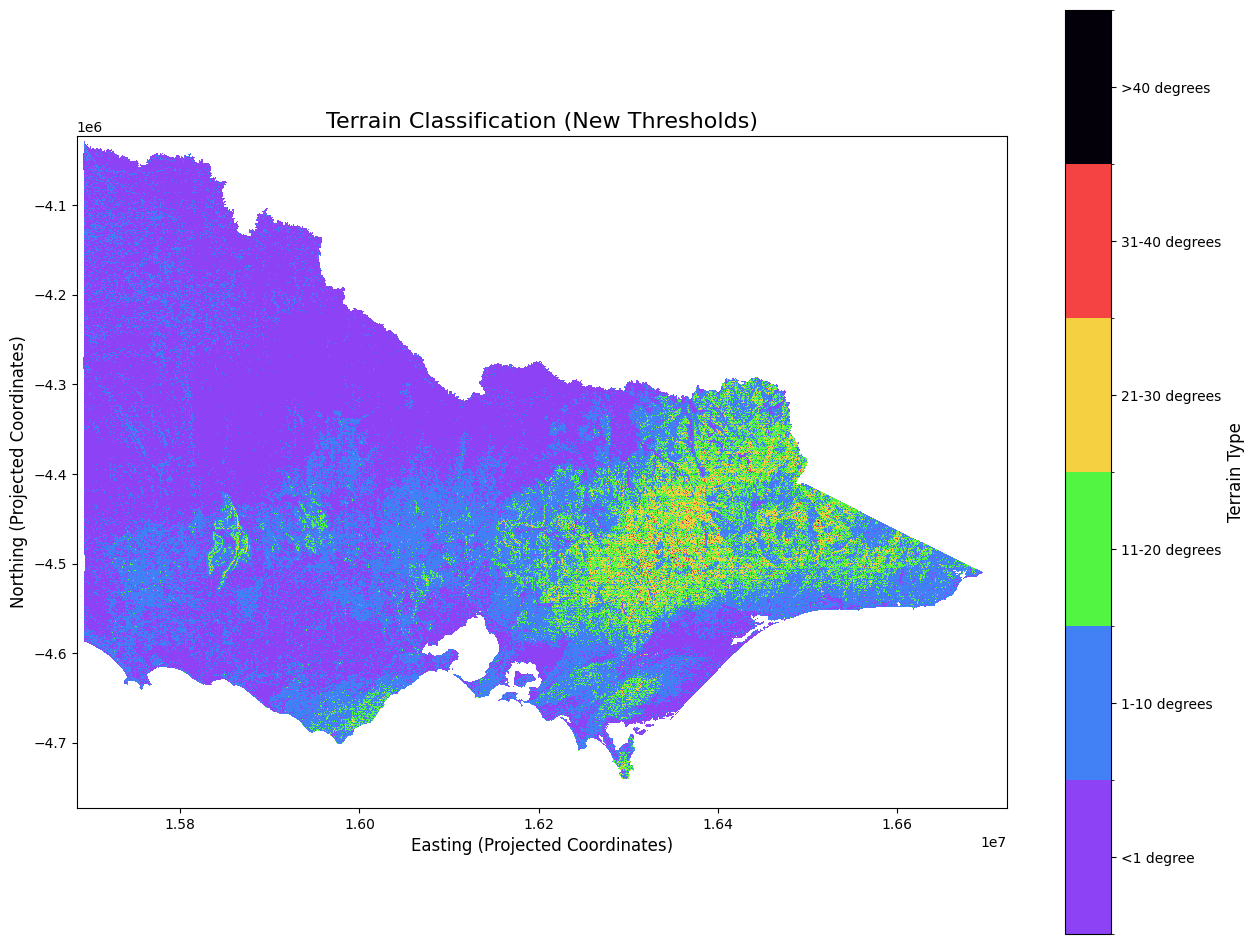


Summary of Updated Terrain Classification:
Percentage of Category 0 (<1 degree): 51.71%
Percentage of Category 1 (1-10 degrees): 35.32%
Percentage of Category 2 (11-20 degrees): 9.60%
Percentage of Category 3 (21-30 degrees): 3.09%
Percentage of Category 4 (31-40 degrees): 0.27%
Percentage of Category 5 (>40 degrees): 0.00%


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import rasterio

# Define colors for the custom colormap
colors = ['#8d42f5', '#4281f5', '#51f542', '#f5d142', '#f54242', '#04000a']
cmap = ListedColormap(colors)

# Define boundaries for the BoundaryNorm based on the six terrain categories
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
norm = BoundaryNorm(bounds, cmap.N)

# Open the file_path with rasterio to retrieve src.bounds for plot extent
with rasterio.open(file_path) as src:
    plot_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Use plt.imshow() to display the terrain_classification_new array
plt.figure(figsize=(15, 12))
plt.imshow(terrain_classification_new, cmap=cmap, norm=norm, origin='upper', interpolation='nearest', extent=plot_extent)

# Add a title to the plot
plt.title('Terrain Classification (New Thresholds)', fontsize=16)
plt.xlabel('Easting (Projected Coordinates)', fontsize=12)
plt.ylabel('Northing (Projected Coordinates)', fontsize=12)

# Create a colorbar for the plot
cbar = plt.colorbar(ticks=[0, 1, 2, 3, 4, 5])
cbar.set_ticklabels(['<1 degree', '1-10 degrees', '11-20 degrees', '21-30 degrees', '31-40 degrees', '>40 degrees'])
cbar.set_label('Terrain Type', fontsize=12)

# Display the plot
plt.show()

# Print a summary of the calculated percentages
print(f"\nSummary of Updated Terrain Classification:")
print(f"Percentage of Category 0 (<1 degree): {percentage_cat0:.2f}%")
print(f"Percentage of Category 1 (1-10 degrees): {percentage_cat1:.2f}%")
print(f"Percentage of Category 2 (11-20 degrees): {percentage_cat2:.2f}%")
print(f"Percentage of Category 3 (21-30 degrees): {percentage_cat3:.2f}%")
print(f"Percentage of Category 4 (31-40 degrees): {percentage_cat4:.2f}%")
print(f"Percentage of Category 5 (>40 degrees): {percentage_cat5:.2f}%")

## Summary:

### Q&A
The updated percentages for each of the six terrain categories are:
*   Less than 1 degree: 51.71%
*   1-10 degrees: 35.32%
*   11-20 degrees: 9.60%
*   21-30 degrees: 3.09%
*   31-40 degrees: 0.27%
*   40 degrees and beyond: 0.00%

### Data Analysis Key Findings
*   The terrain was successfully reclassified into six new categories based on slope thresholds: less than 1 degree, 1-10 degrees, 11-20 degrees, 21-30 degrees, 31-40 degrees, and 40 degrees and beyond.
*   The majority of the terrain (51.71%) has a slope of less than 1 degree, indicating a predominantly flat or gently sloping landscape.
*   A significant portion, 35.32%, falls into the 1-10 degree slope range, representing moderately sloped areas.
*   Steeper terrains (11-20 degrees) account for 9.60% of the area, while very steep terrains (21-30 degrees) make up 3.09%.
*   Extremely steep terrains (31-40 degrees) are rare, comprising only 0.27%, and areas with slopes of 40 degrees or more are negligible, at 0.00%.
*   A visualization of the new terrain classification was generated using a custom colormap, effectively depicting the different slope categories across the landscape.




# Task
Crop the GeoTIFF file "vicdem_30m_merged_clipped_3857.tif" to the following geographic bounding box: easting from 16,100,000 to 16,700,000, and northing from -4,800,000 to -4,200,000. Save the cropped GeoTIFF as 'cropped_map.tif' and report its file size.

In [ ]:
import rasterio

# Define the easting and northing ranges based on the user's request, converted to full coordinate values
min_easting = 15700000  # Corresponding to 1.61
max_easting = 15800000  # Corresponding to 1.67
min_northing = -4300000 # Corresponding to -4.8
max_northing = -4250000 # Corresponding to -4.2

# Re-define file_path from previous cells
file_path = '/content/drive/MyDrive/vicdem_30m_merged_clipped_3857.tif'

# Open the source GeoTIFF file using rasterio
with rasterio.open(file_path) as src:
    # Use the src.window() method to calculate the pixel window
    # The order of coordinates for window() is left, bottom, right, top
    window = src.window(min_easting, min_northing, max_easting, max_northing)

print(f"Defined Easting Range: {min_easting} to {max_easting}")
print(f"Defined Northing Range: {min_northing} to {max_northing}")
print(f"Calculated pixel window: {window}")

Defined Easting Range: 15700000 to 15800000
Defined Northing Range: -4300000 to -4250000
Calculated pixel window: Window(col_off=np.float64(462.08350381895434), row_off=np.float64(6879.785348878679), width=np.float64(3029.297218185442), height=np.float64(1514.648609092721))


In [ ]:
import rasterio
import os

# Re-define file_path (if not already in scope) and output file path
file_path = '/content/drive/MyDrive/vicdem_30m_merged_clipped_3857.tif'
output_file_path = '/content/drive/MyDrive/new3_cropped_map.tif'

# Define the easting and northing ranges based on the user's request, converted to full coordinate values
min_easting = 15700000
max_easting = 15800000
min_northing = -4300000
max_northing = -4250000

with rasterio.open(file_path) as src:
    # Calculate the window for the desired crop
    window = src.window(min_easting, min_northing, max_easting, max_northing)

    # Read the data within the calculated window
    cropped_data = src.read(1, window=window)

    # Update the metadata for the cropped file
    profile = src.profile
    profile.update({
        'height': cropped_data.shape[0],
        'width': cropped_data.shape[1],
        'transform': src.window_transform(window)
    })

    # Write the cropped data to a new GeoTIFF file
    with rasterio.open(output_file_path, 'w', **profile) as dst:
        dst.write(cropped_data, 1)

print(f"Cropped GeoTIFF saved to: {output_file_path}")

# Get the file size of the cropped GeoTIFF
file_size_bytes = os.path.getsize(output_file_path)
file_size_mb = file_size_bytes / (1024 * 1024)
print(f"Cropped file size: {file_size_mb:.2f} MB")

Cropped GeoTIFF saved to: /content/drive/MyDrive/new3_cropped_map.tif
Cropped file size: 17.51 MB
